In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
"""
This is a test of spectra generation with pspy and namaster for spin0 fields.
It is done in HEALPIX pixellisation
"""
import matplotlib
from pspy import so_map,so_window,so_mcm,sph_tools,so_spectra, pspy_utils
import healpy as hp, numpy as np, pylab as plt
import os
import pymaster as nmt

In [3]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
            break
        elif counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

In [4]:
! ls ../../../

bbltxt		 data		 LICENSE	   pspy.egg-info     temp
bin		 dist		 NERSC_INSTALL.md  README.md	     test
build		 docs		 paramfiles	   requirements.txt
configs		 example_bashrc  project	   runsims.ipynb
CONTRIBUTING.md  global.dict	 pspy		   setup.py


## Generate Maps but use Planck Mask, Compute NaMaster

In [5]:
#We  specify the HEALPIX survey parameter, it will be a disk of radius 25 degree centered on longitude 30 degree and latitude 50 degree
# It will have a resolution nside=1024
lon,lat=30,50
radius=100
nside=2048
# ncomp=1 mean that we are going to use only spin0 field (ncomp=3 for spin 0 and 2 fields
ncomp=1
# clfile are the camb lensed power spectra
clfile='../../../data/bode_almost_wmap5_lmax_1e4_lensedCls_startAt2.dat'
# a binningfile with format, lmin,lmax,lmean
binning_file='../../../data/binningFile_100_50.dat'
# the maximum multipole to consider
lmax=3*nside-1
# the number of iteration in map2alm
niter=3
# the noise on the spin0 component
rms_uKarcmin_T=20
# the apodisation lengh for the survey mask (in degree)
apo_radius_degree_survey=1
# the number of holes in the point source mask
source_mask_nholes=100
# the radius of the holes (in arcminutes)
source_mask_radius=10
# the apodisation lengh for the point source mask (in degree)
apo_radius_degree_mask=0.3
# the type of power spectrum (Cl or Dl)
type='Cl'

test_dir='result_pspyVSnamaster_spin0'
try:
    os.makedirs(test_dir)
except:
    pass

# the templates for the CMB splits
template= so_map.healpix_template(ncomp,nside=nside)

mask = hp.read_map(f'../masks/COM_Mask_Likelihood-temperature-{217}_2048_R2.00.fits', verbose=False)

#First let's generate a CMB realisation
cmb=template.synfast(clfile)
split=cmb.copy()
#let's add noise to it with rms 20 uk.arcmin
noise = so_map.white_noise(split,rms_uKarcmin_T=rms_uKarcmin_T)
split.data+=noise.data

#we then apodize the survey mask
# window=so_window.create_apodization(binary, apo_type='C1', apo_radius_degree=apo_radius_degree_survey)
#we create a point source mask
# mask=so_map.simulate_source_mask(binary, nholes=source_mask_nholes, hole_radius_arcmin=source_mask_radius)
#... and we apodize it
# mask= so_window.create_apodization(mask, apo_type='C1', apo_radius_degree=apo_radius_degree_mask)
#the window is given by the product of the survey window and the mask window
# window.data*=mask.data


binleft, binright = np.genfromtxt('../planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    
ells = np.arange(3*nside)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([1 for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()


# Compute spin 0 spectra a la namaster
# nlb=50
field=nmt.NmtField(mask,[split.data])
cl_coupled=nmt.compute_coupled_cell(field,field)
# b=nmt.NmtBin(nside,nlb=nlb)
# lb=b.get_effective_ells()
w0=nmt.NmtWorkspace()
w0.compute_coupling_matrix(field,field,b)
Cb_namaster=w0.decouple_cell(cl_coupled)

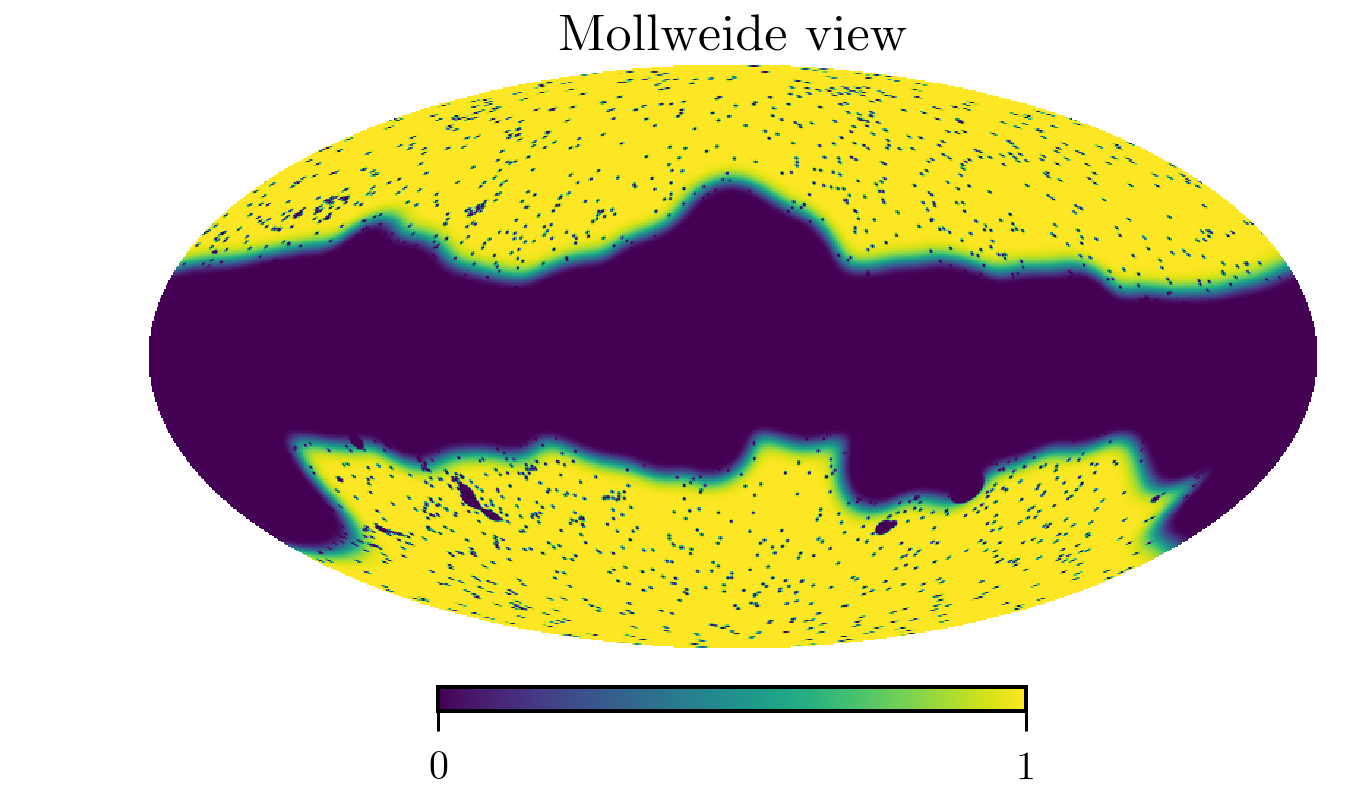

In [6]:
hp.mollview(mask)

In [7]:
import ispice

In [8]:
hp.write_map('window.fits', mask, overwrite=True)
hp.write_map('split.fits', split.data, overwrite=True)

In [9]:
ispice.ispice(mapin1='split.fits', weightfile1='window.fits',
              mapfile2='split.fits', weightfile2='window.fits',
              apodizesigma=180, thetamax=180, subdipole='YES', subav='YES',
              clout='cl.fits')

Submitting job 0
/home/zequnl/Installs/PolSpice_v03-05-01/bin/./spice -apodizesigma 180 -apodizetype 0 -beam NO -beam2 NO -clfile cl.fits -decouple NO -mapfile split.fits -mapfile2 split.fits -fits_out YES -weightfile window.fits -weightfile2 window.fits -nlmax -1 -normfac 1.00000 -npairsthreshold 0.00000 -overwrite YES -polarization NO -pixelfile YES -pixelfile2 YES -subav YES -subdipole YES -symmetric_cl NO -thetamax 180 -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 


0

In [10]:
from astropy.io import fits
pixwin = hp.sphtfunc.pixwin(nside)
rawcl = fits.open('cl.fits')[1].data['TT'] * pixwin**2

ValueError: operands could not be broadcast together with shapes (3101,) (6144,) 

Have to bin it ourselves...

In [ ]:
binleft, binright = np.genfromtxt('planck_spectra//binused.dat', 
                                          unpack=True, usecols=(0,1), dtype=((int), (int)))

binleft, binright = binleft, binright
ells = np.arange(len(rawcl))
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
    
binned_ell = np.array([ np.sum(ells[bpws==bp])/np.sum(bpws==bp)
                       for bp in range(len(binleft)) ])

Cb_polspice = np.array([ np.sum(
        rawcl[bpws==bp]) / np.sum(bpws==bp) 
                          for bp in range(len(binleft)) ])

In [ ]:
plt.plot(lb,Cb_namaster[0]*lb**2/(2*np.pi),'.',label='namaster')
plt.plot(binned_ell,Cb_polspice*binned_ell**2/(2*np.pi), 'r.', marker='+', label='polspice')
plt.ylabel(r'$D_{\ell}$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)
plt.legend()

In [ ]:
plt.figure(figsize=(12,6))
plt.axhline(0, color='red', alpha=0.3)
# plot the fractional difference
# plt.plot(lb_pspy,(Cb_pspy-Cb_namaster[0][:100])/Cb_namaster[0][:100], label='pspy')
plt.ylabel(r'$(D_{\ell}^{\mathrm{polspice}} - D^{\rm nmt}_{\ell}) / \sigma$',fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)

lmin_,lmax_,l,cl,error=np.loadtxt('planck_spectra/spectra_' + f'TT_{143}x{143}' + '.dat',unpack=True)
# plot the fractional difference
plt.plot(lb[len(bonus_left):-16],
         (Cb_polspice-Cb_namaster[0][len(bonus_left):])[:-16]/error, 'k.-', label='polspice')

plt.ylim(-3, 3)
plt.legend()